<h1>День 2. Модели склонности</h1>

<h3>Сервисный модуль</h3>
<b><i>Пожалуйста, запустите следующие несколько ячеек при первом запуске ноутбука!</i></b>

In [275]:
import warnings
warnings.filterwarnings('ignore')

In [276]:
%pip install -r '/home/jupyter/work/resources/a2nced/requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
  Using cached tornado-6.1-cp38-cp38-manylinux2010_x86_64.whl (427 kB)
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [277]:
import os
import sys
from pathlib import Path
dir_path = Path(os.getcwd()).resolve().parent.as_posix()
sys.path.append(dir_path)

<h3>Конец сервисного модуля</h3>

<br>
<h1>Практика 1</h1>
<h3>Построение базовой модели склонности</h3>
<br>
<h4>Подготовка данных</h4>

In [278]:
# необходимые импорты
import pandas as pd
import numpy as np
import datetime as dt

In [279]:
# необходимые импорты
import sklearn
from lightgbm import LGBMClassifier

In [280]:
# найдем директорию, в которой хранятся наши данные
_PATH = '/home/jupyter/mnt/s3/course-test/day_2/'

In [281]:
# укажем пути до конкретных файлов
transactions_path = os.path.join(_PATH, 'day_2_transactions.csv') # транзакции
demographics_path = os.path.join(_PATH, 'day_2_demogr.csv') # информация о клиентах
prod_path         = os.path.join(_PATH, 'day_2_product.csv') # информация о товарах
orders_path       = os.path.join(_PATH, 'day_2_orders.csv') # информация о заказах, сгруппированная по корзинам

In [282]:
# загрузим данные
transactions_df = pd.read_csv(transactions_path)
transactions_df['purch_date_time'] = transactions_df['purch_date_time'].astype(np.datetime64)

In [283]:
demographics = pd.read_csv(demographics_path)
prod_df = pd.read_csv(prod_path)

In [284]:
# загрузим данные по заказам, которые мы собрали на прошлом занятии
orders_df = pd.read_csv(orders_path)
orders_df['purch_date_time'] = orders_df['purch_date_time'].astype(np.datetime64)
orders_df.head()

user_id    basket_id     purch_date_time  quantity  sales_value  \
0        1  27601281299 2018-09-19 15:56:00        34        78.66   
1        1  27774192959 2018-10-05 21:02:00        14        41.10   
2        1  28024266849 2018-10-26 17:04:00        13        26.90   
3        1  28106322445 2018-11-01 20:37:00        32        63.43   
4        1  28235481967 2018-11-08 17:03:00        20        53.45   

   retail_disc  default_price  
0       -16.54          96.20  
1        -8.59          49.69  
2        -6.72          33.62  
3       -11.08          76.51  
4       -16.42          69.87

In [285]:
available_ids = demographics['user_id'].values

<br>
<h4>Автоматическая генерация признаков</h4>

In [286]:
# Перед началом работы необходимо описать наши данные и связи между ними

In [287]:
import featuretools as ft
ft.__version__

'1.18.0'

In [288]:
# для удобства оформим повторно используемый код в виде функции
def create_feature_matrix(entity_set:ft.entityset.entityset.EntitySet,
                          cutoff:str,
                          common_cols:list=['user_id', 'age_desc', 'income_desc',
                                            'have_own_house', 'num_adults',
                                            'adult_gender', 'no_kids', 'size']
                         ) -> pd.DataFrame:
    feature_matrix_14, feature_defs_14 = ft.dfs(entityset=entity_set,
                                          target_dataframe_name='customer_info',
                                          cutoff_time=cutoff,
                                          training_window="14 days",
                                          verbose=True)
    feature_matrix_30, feature_defs_30 = ft.dfs(entityset=entity_set,
                                          target_dataframe_name='customer_info',
                                          cutoff_time=cutoff,
                                          training_window="30 days",
                                          verbose=True)
    feature_matrix_60, feature_defs_60 = ft.dfs(entityset=entity_set,
                                          target_dataframe_name='customer_info',
                                          cutoff_time=cutoff,
                                          training_window="60 days",
                                          verbose=True)
    
    feature_matrix_14 = feature_matrix_14.reset_index()
    feature_matrix_30 = feature_matrix_30.reset_index()
    feature_matrix_60 = feature_matrix_60.reset_index()
    feature_matrix_14.columns = feature_matrix_14.columns.map(lambda x: f'{x}_14_days' if x not in common_cols else str(x))
    feature_matrix_30.columns = feature_matrix_30.columns.map(lambda x: f'{x}_30_days' if x not in common_cols else str(x))
    feature_matrix_60.columns = feature_matrix_60.columns.map(lambda x: f'{x}_60_days' if x not in common_cols else str(x))
    feature_matrix = feature_matrix_14.merge(feature_matrix_30, how='left')
    feature_matrix = feature_matrix.merge(feature_matrix_60, how='left')
    return(feature_matrix)

In [289]:
# теперь создадим описание нашей модели данных для создания витрин

In [290]:
# чтобы получить агрегаты, мы должны указать объекты и связи между ними
# для этого создаем отдельную сущность
es = ft.EntitySet("a2nced_sample_2")

In [291]:
# создадим уникальное поле для каждой позиции в каждом заказе transactions_df
transactions_df['record_id'] = transactions_df.index

In [292]:
# обогатим наши данные информацией о продуктах
trans_catig_df = transactions_df.merge(prod_df[['product_id', 'manufacturer',
                                                'department', 'brand']],
                                       how='left',
                                       on='product_id')
trans_catig_df.head()

user_id     purch_date_time    basket_id  product_id  quantity  \
0     2375 2018-07-31 17:31:00  26984851472     1004906         1   
1     2375 2018-07-31 17:31:00  26984851472     1033142         1   
2     2375 2018-07-31 17:31:00  26984851472     1036325         1   
3     2375 2018-07-31 17:31:00  26984851472     1082185         1   
4     2375 2018-07-31 17:31:00  26984851472     8160430         1   

   sales_value  retail_disc  default_price  record_id  manufacturer  \
0         1.39        -0.60           1.99          0            69   
1         0.82         0.00           0.82          1             2   
2         0.99        -0.30           1.29          2            69   
3         1.21         0.00           1.21          3             2   
4         1.50        -0.39           1.89          4            69   

  department     brand  
0    PRODUCE   Private  
1    PRODUCE  National  
2    PRODUCE   Private  
3    PRODUCE  National  
4    PRODUCE   Private

In [293]:
# укажем логические типы данных, которые не следуют явно из типов хранимых данных:
# иначе он будет вычислять среднее значение id производителя
customer_info_types = {
    'user_id': "Categorical",
    'age_desc': "Categorical",
    'income_desc': "Categorical",
    'have_own_house': "BooleanNullable",
    'num_adults': "Categorical",
    'adult_gender': "Categorical",
    'no_kids': "BooleanNullable",
    'size': "Categorical"
}

products_types = {
    'product_id': "Categorical",
    'manufacturer': "Categorical",
    'department': "Categorical",
    'brand': "Categorical",
    'commodity_desc': "Categorical",
    'sub_commodity_desc': "Categorical",
    'curr_size_of_product': "Categorical"
}

orders_types = {
    'user_id': "Categorical",
    'basket_id': "Categorical",
    'purch_date_time': "Datetime",
    'quantity': "Double",
    'sales_value': "Double",
    'retail_disc': "Double",
    'default_price': "Double"    
}

transactions_types ={
    'user_id': "Categorical",
    'purch_date_time': "Datetime",
    'basket_id': "Categorical",
    'product_id': "Categorical",
    'quantity': "Double",
    'sales_value': "Double",
    'retail_disc': "Double",
    'default_price': "Double",
    'record_id': "Categorical",
    'manufacturer': "Categorical",
    'department': "Categorical",
    'brand': "Categorical",
}

In [294]:
# сначала добавим созданные датафреймы
es.add_dataframe(dataframe_name='customer_info',
                 dataframe=demographics,
                 logical_types=customer_info_types,
                 index='user_id')

es.add_dataframe(dataframe_name='orders',
                 dataframe=orders_df,
                 logical_types=orders_types,
                 index='basket_id',
                 time_index='purch_date_time')

es.add_dataframe(dataframe_name='transactions',
                 dataframe=trans_catig_df.loc[trans_catig_df.user_id.isin(available_ids)],
                 logical_types=transactions_types,
                 index='record_id',
                 time_index='purch_date_time')

es.add_dataframe(dataframe_name='products',
                 dataframe=prod_df,
                 logical_types=products_types,
                 index='product_id')

Entityset: a2nced_sample_2
  DataFrames:
    customer_info [Rows: 801, Columns: 8]
    orders [Rows: 276484, Columns: 7]
    transactions [Rows: 1427303, Columns: 12]
    products [Rows: 92353, Columns: 7]
  Relationships:
    No relationships

In [295]:
es.add_relationship('customer_info', 'user_id', 'orders', 'user_id')
es.add_relationship('customer_info', 'user_id', 'transactions', 'user_id')
es.add_relationship('orders', 'basket_id', 'transactions', 'basket_id')
es.add_relationship('products', 'product_id', 'transactions', 'product_id')

Entityset: a2nced_sample_2
  DataFrames:
    customer_info [Rows: 801, Columns: 8]
    orders [Rows: 276484, Columns: 7]
    transactions [Rows: 1427303, Columns: 12]
    products [Rows: 92353, Columns: 7]
  Relationships:
    orders.user_id -> customer_info.user_id
    transactions.user_id -> customer_info.user_id
    transactions.basket_id -> orders.basket_id
    transactions.product_id -> products.product_id

<h4>Сбор обучающей выборки</h4>

In [296]:
# получим нашу витрину с агрегатами за 14, 30 и 60 дней с помощью функции, которую мы описали ранее

feature_matrix = create_feature_matrix(es, '2018-10-08') # нужно указать источник данных и дату среза

Built 331 features
Elapsed: 00:05 | Progress: 100%|██████████
Built 331 features
Elapsed: 00:07 | Progress: 100%|██████████
Built 331 features
Elapsed: 00:08 | Progress: 100%|██████████


<h4>Разметка целевого события</h4>

In [297]:
# соберем сведения о наиболее популярных продуктах
# важно использовать именно count(), иначе мы получим информацию по заправке, а не по собственно, магазину
top_10_prods = transactions_df.groupby('product_id')['quantity'].count().reset_index().sort_values('quantity', ascending=False).head(10)

In [298]:
start_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=1)
end_period =  dt.datetime.strptime('2019-07-01', '%Y-%m-%d')  + dt.timedelta(days=14)

In [299]:
# соберем_таргет

prod_id = top_10_prods.product_id.values[0]

target_mask = ((transactions_df['user_id'].isin(available_ids)) &\
              (transactions_df['purch_date_time'] >= start_period) &\
              (transactions_df['purch_date_time'] <= end_period) &\
              (transactions_df['product_id'] == prod_id))

target = pd.DataFrame()
target['user_id'] = transactions_df.loc[target_mask]['user_id'].unique()
target['product_id'] = prod_id

# маркируем целевое действие - совершение покупки
target['y'] = 1
target.head()

user_id  product_id  y
0      157     1082185  1
1      314     1082185  1
2     1453     1082185  1
3      696     1082185  1
4     2318     1082185  1

In [300]:
df_one_prod = feature_matrix.merge(target, how='left')
df_one_prod['y'] = df_one_prod['y'].fillna(0).astype('int8')

In [301]:
X = df_one_prod.drop(['user_id', 'product_id', 'y'], axis=1)
y = df_one_prod.y

In [303]:
y.value_counts()

0    555
1    246
Name: y, dtype: int64

In [336]:
# lightgbm не дружит с типом данных 'category'
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')

    
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

In [337]:
# сохраним наши данные на будущее для применения в калиброванной модели
X_calib, y_calib = X, y

In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [306]:
categorical_features = X.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

<h4>Подбор оптимальных гиперпараметров и обучение модели</h4>

In [307]:
from utils.models import create_pipeline, param_search, search_space, unpack_model_params

In [308]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [309]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [07:02<00:00,  4.23s/trial, best loss: -0.5564204480101218]


In [310]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['have_own_house',
                                                   'num_adults', 'no_kids',
                                                   'COUNT(orders)_14_days',
                                                   'MAX(orders.default_price)_14_days',
                                                   'MAX(orders.quantity)_14_days',
                                                   'MAX(orders.retail_disc)_14_days',
                                                   'MAX(orders.sales_value)_14_days',
                                                   '...
       'MODE(orders.MODE(transactions.brand))_60_days',
       'MODE(orders.MODE(transactions.department))_60_days'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.005411237994161011,
                                max_depth=12, n_estimators=150, n_jobs=8,
                                num_leaves=52, objective='binary',
                                random_state=42, reg_alpha=0.30107598975233446,
                                reg_lambda=0.12076806111174014))])

In [311]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['have_own_house',
                                                   'num_adults', 'no_kids',
                                                   'COUNT(orders)_14_days',
                                                   'MAX(orders.default_price)_14_days',
                                                   'MAX(orders.quantity)_14_days',
                                                   'MAX(orders.retail_disc)_14_days',
                                                   'MAX(orders.sales_value)_14_days',
                                                   '...
       'MODE(orders.MODE(transactions.brand))_60_days',
       'MODE(orders.MODE(transactions.department))_60_days'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.005411237994161011,
                                max_depth=12, n_estimators=150, n_jobs=8,
                                num_leaves=52, objective='binary',
                                random_state=42, reg_alpha=0.30107598975233446,
                                reg_lambda=0.12076806111174014))])

In [312]:
y_pred = pipeline.predict(X_test)

In [313]:
prob_pred = pipeline.predict_proba(X_test)

In [314]:
from sklearn.metrics import accuracy_score, plot_roc_curve
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.6766169154228856


In [315]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [316]:
feature_matrix_oot = create_feature_matrix(es, '2019-07-15')

Built 331 features
Elapsed: 00:10 | Progress: 100%|██████████
Built 331 features
Elapsed: 00:16 | Progress: 100%|██████████
Built 331 features
Elapsed: 00:26 | Progress: 100%|██████████


In [317]:
start_period_oot = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=1)
end_period_oot = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=14)

In [318]:
# соберем таргет
target_mask = ((transactions_df['user_id'].isin(available_ids)) &\
              (transactions_df['purch_date_time'] >= start_period) &\
              (transactions_df['purch_date_time'] <= end_period) &\
              (transactions_df['product_id'] == prod_id))

target_oot = pd.DataFrame()
target_oot['user_id'] = transactions_df.loc[target_mask]['user_id'].unique()
target_oot['product_id'] = prod_id

# маркируем целевое действие - совершение покупки
target_oot['y'] = 1
target_oot.head()

user_id  product_id  y
0      157     1082185  1
1      314     1082185  1
2     1453     1082185  1
3      696     1082185  1
4     2318     1082185  1

In [319]:
df_prod_oot = feature_matrix_oot.merge(target_oot, how='left')

In [320]:
df_prod_oot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Columns: 982 entries, user_id to y
dtypes: Int64(72), boolean(2), category(68), float64(839), int64(1)
memory usage: 6.5 MB


In [321]:
df_prod_oot['y'] = df_prod_oot['y'].fillna(0).astype('int8')

In [322]:
X_oot = df_prod_oot.drop(['user_id', 'product_id', 'y'], axis=1)
y_oot = df_prod_oot.y

In [323]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [324]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.7265917602996255


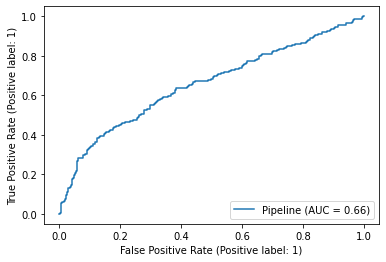

In [325]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [326]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
436  0.355013  0.644987  0
703  0.356652  0.643348  0
745  0.362771  0.637229  1
80   0.367258  0.632742  0
582  0.376636  0.623364  1
718  0.377348  0.622652  1
535  0.378861  0.621139  1
588  0.379973  0.620027  1
564  0.384470  0.615530  1
76   0.386940  0.613060  1

In [327]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
436  0.644987  0           0         1   0.000000      1.001248     0.000000   
703  0.643348  0           0         2   0.000000      1.002497     0.000000   
745  0.637229  1           1         3   0.004065      1.003745     0.004065   
80   0.632742  0           1         4   0.004065      1.004994     0.000000   
582  0.623364  1           2         5   0.008130      1.006242     0.004065   
718  0.622652  1           3         6   0.012195      1.007491     0.004065   
535  0.621139  1           4         7   0.016260      1.008739     0.004065   
588  0.620027  1           5         8   0.020325      1.009988     0.004065   
564  0.615530  1           6         9   0.024390      1.011236     0.004065   
76   0.613060  1           7        10   0.028455      1.012484     0.004065   

     position_diff   derivative  sum_derivative  
436       0.000000     0.000000        0.000000  
703       0.001248  1248.439451     1248.439451  
745       0.001248     0.307041     1248.746491  
80        0.001248  1248.439451     2497.185942  
582       0.001248     0.307041     2497.492983  
718       0.001248     0.307041     2497.800023  
535       0.001248     0.307041     2498.107064  
588       0.001248     0.307041     2498.414104  
564       0.001248     0.307041     2498.721145  
76        0.001248     0.307041     2499.028185

In [328]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

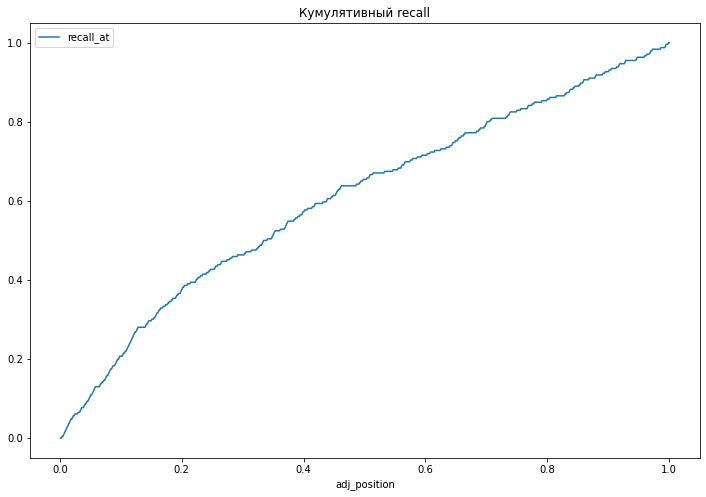

In [329]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [330]:
from utils.metrics import find_inflection_point
cutoff = find_inflection_point(scores_sorted, 5, 4, X.shape[0])

In [331]:
cutoff

115

In [332]:
cutoff = cutoff / scores_sorted.shape[0]

In [333]:
import pickle

_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_base_prop.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

<h4>Формирование сегмента клиентов для пилота</h4>

In [ ]:
feature_matrix_score = create_feature_matrix(es, '2019-07-29')

In [ ]:
X_score = feature_matrix_score.drop('user_id', axis=1)

In [ ]:
scores = pipeline.predict_proba(X_score)

In [ ]:
score_df = pd.DataFrame()
score_df['customer_id'] = feature_matrix_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [ ]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

<h3>Домашнее задание 1</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: покупка клиентом другого популярного товара.<br>
<b><i>Подсказка:</i></b> Используйте любой другой товар из собранной нами топ-10 популярных товаров.

<br>
<h1>Практика 2</h1>
<h3>Углубленное целевое событие</h3>
<br>
<h4>Сбр обучающей выборки</h4>

In [ ]:
# таргет - две покупки в выбранной категории

In [ ]:
df = feature_matrix.copy()

In [ ]:
department_name = 'PASTRY'
start_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=1)
end_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=21)

<h4>Разметка целевого события</h4>

In [ ]:
mask_target = (trans_catig_df['purch_date_time'] >= start_period) &\
                (trans_catig_df['purch_date_time'] <= end_period) &\
                (trans_catig_df['department'] == department_name) &\
                (trans_catig_df.user_id.isin(available_ids))

In [ ]:
target = trans_catig_df.loc[mask_target].groupby('user_id')['basket_id'].nunique().reset_index()

In [ ]:
target['y'] = target['basket_id'].apply(lambda x: 1 if x >= 2 else 0)
target = target[['user_id', 'y']]
target['y'].value_counts()

<h3>Домашнее задание 2</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: покупка клиентом определенного товара два или более раз в период двух недель от даты витрины.<br>
<b><i>Подсказка:</i></b> Можете использовать любой id продукта.

<h3>Домашнее задание 3</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: покупка клиентом определенного товара в период двух недель от даты витрины или три и более покупки этого же товара в период четырех недель от даты витрины.<br>
<b><i>Подсказка:</i></b> Покупки в период четырех недель от даты витрины включают и покупку в период двух недель от даты витрины.

<h3>Домашнее задание 4</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: покупка клиентом определенного товара в период одной недели от даты витрины и покупка того же товара в период третьей-четвертой недель от даты витрины.<br>
<b><i>Подсказка:</i></b> Попробуйте применить подход на основе множеств.

In [ ]:
df = df.merge(target, how='left', on='user_id')
df['y'] = df['y'].fillna(0)
df['y'] = df['y'].astype('int8')

In [ ]:
X = df.drop(columns=['user_id', 'y'], axis=1)
y = df['y']

In [ ]:
y.value_counts()

In [ ]:
# lightgbm не дружит с типом данных 'category'
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')

    
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [ ]:
categorical_features = X.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

<h4>Подбор оптимальных гиперпараметров и обучение модели</h4>

In [ ]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [ ]:
best = param_search(pipeline, X_train, y_train, search_space)

In [ ]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
prob_pred = pipeline.predict_proba(X_test)

In [ ]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [ ]:
start_period = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=1)
end_period = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=21)

mask_target_oot = (trans_catig_df['purch_date_time'] >= start_period) &\
                (trans_catig_df['purch_date_time'] <= end_period) &\
                (trans_catig_df['department'] == department_name) &\
                (trans_catig_df.user_id.isin(available_ids))


target_oot = trans_catig_df.loc[mask_target_oot].groupby('user_id')['basket_id'].nunique().reset_index()


target_oot['y'] = target_oot['basket_id'].apply(lambda x: 1 if x >= 2 else 0)
target_oot = target_oot[['user_id', 'y']]
target_oot['y'].value_counts()

df_oot = feature_matrix_oot.copy()

df_oot = df_oot.merge(target_oot, how='left', on='user_id')
df_oot['y'] = df_oot['y'].fillna(0)
df_oot['y'] = df_oot['y'].astype('int8')
df_oot.y.value_counts()

In [ ]:
y_oot = df_oot['y']
X_oot = df_oot.drop(columns=['user_id', 'y'], axis=1)

In [ ]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [ ]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

In [ ]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [ ]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

In [ ]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

In [ ]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

In [ ]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [ ]:
cutoff = find_inflection_point(scores_sorted, 5, 4, 801)

In [ ]:
cutoff

In [ ]:
cutoff = cutoff / scores_sorted.shape[0]

In [ ]:
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_comp_target.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

<h4>Формирование сегмента клиентов для пилота</h4>

In [ ]:
X_score = feature_matrix_score.drop('user_id', axis=1)

In [ ]:
scores = pipeline.predict_proba(X_score)

In [ ]:
score_df = pd.DataFrame()
score_df['customer_id'] = feature_matrix_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [ ]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

<br>
<h1>Практика 3</h1>
<h3>Построение единой модели склонности для нескольких продуктов</h3>

<h4>Сбор обучающей выборки</h4>

In [ ]:
# подготовим датафрейм, который будет содержать признаки продукта
prod_features = pd.DataFrame()
for prod_id in top_10_prods.product_id.values:
    temp_df = pd.DataFrame()
    temp_df['user_id'] = available_ids
    temp_df['product_id'] = prod_id
    prod_features = pd.concat([prod_features, temp_df], axis=0)

In [ ]:
def get_targets(start_period, end_period):
    targets = pd.DataFrame()
    for prod_id in top_10_prods.product_id.values:
        target_mask = ((transactions_df['user_id'].isin(available_ids)) &\
                      (transactions_df['purch_date_time'] >= start_period) &\
                      (transactions_df['purch_date_time'] <= end_period) &\
                      (transactions_df['product_id'] == prod_id))

        target = pd.DataFrame()
        target['user_id'] = transactions_df.loc[target_mask]['user_id'].unique()
        target['product_id'] = prod_id

        # маркируем целевое действие - совершение покупки
        target['y'] = 1
        targets = pd.concat([targets, target], axis=0)
    return(targets)

In [ ]:
start_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=1)
end_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=21)
targets = get_targets(start_period, end_period)

In [ ]:
df_prod = prod_features.merge(feature_matrix, how='left')
df_prod = df_prod.merge(targets, how='left', on=['user_id', 'product_id'])

In [ ]:
df_prod['y'] = df_prod['y'].fillna(0).astype('int8')

In [ ]:
df_prod = df_prod.sample(2000)

In [ ]:
df_prod.head(20)

In [ ]:
X = df_prod.drop(['user_id', 'y'], axis=1)
y = df_prod.y

In [ ]:
# lightgbm не дружит с типом данных 'category'
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')

    
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

In [ ]:
y.value_counts()

In [ ]:
categorical_features = X_train.select_dtypes(exclude=['Int64', 'float64']).columns.values
categorical_features = np.append(categorical_features, 'product_id')
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [ ]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [ ]:
# снизим количество эпох, чтобы емного ускорить обучение
best = param_search(pipeline, X_train, y_train, search_space, 50)

In [ ]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
prob_pred = pipeline.predict_proba(X_test)

In [ ]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [342]:
start_period_oot = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=1)
end_period_oot = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=21)

In [343]:
target_oot = get_targets(start_period_oot, end_period_oot)

In [344]:
df_prod_oot = prod_features.merge(feature_matrix_oot, how='left')
df_prod_oot = df_prod_oot.merge(target_oot, how='left')

In [345]:
df_prod_oot['y'] = df_prod_oot['y'].fillna(0).astype('int8')

In [346]:
X_oot = df_prod_oot.drop(['user_id', 'y'], axis=1)
y_oot = df_prod_oot.y

In [347]:
y_oot.value_counts()

0    6643
1    1367
Name: y, dtype: int64

In [ ]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [ ]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

In [ ]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [ ]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

In [ ]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

In [ ]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

In [ ]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [ ]:
cutoff = find_inflection_point(scores_sorted, 5, 4, X.shape[0])

In [ ]:
cutoff

In [ ]:
cutoff = cutoff / scores_sorted.shape[0]

<h3>Калибровка</h3>

In [338]:
# Схожую по функционалу модель можно построить на основе моделей отлклика для одного продукта на основе калибровки

from sklearn.calibration import CalibratedClassifierCV


# загрузим предобученную ранее модель
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_base_prop.pkl')

with open(_FILEPATH, 'rb') as pickle_file:
    fitted_model = pickle.load(pickle_file)
    

# откалибруем уже обученную модель

calibrated_model = CalibratedClassifierCV(base_estimator=fitted_model, cv='prefit', method='isotonic')
calibrated_model.fit(X_calib, y_calib)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('preprocessor',
                                                       ColumnTransformer(transformers=[('numeric',
                                                                                        Pipeline(steps=[('imputer',
                                                                                                         SimpleImputer()),
                                                                                                        ('scaler',
                                                                                                         StandardScaler())]),
                                                                                        ['have_own_house',
                                                                                         'num_adults',
                                                                                         'no_kids',
                                                                                         'COUNT(orders)_14_days',
                                                                                         'MAX(orders.default_price)_14_days',
                                                                                         'MAX(orders.quantity)_14_days',
                                                                                         'MAX(orders.retail_disc)_14_day...
       'MODE(orders.MODE(transactions.brand))_60_days',
       'MODE(orders.MODE(transactions.department))_60_days'], dtype=object))])),
                                                      ('classifier',
                                                       LGBMClassifier(is_unbalance=True,
                                                                      learning_rate=0.005411237994161011,
                                                                      max_depth=12,
                                                                      n_estimators=150,
                                                                      n_jobs=8,
                                                                      num_leaves=52,
                                                                      objective='binary',
                                                                      random_state=42,
                                                                      reg_alpha=0.30107598975233446,
                                                                      reg_lambda=0.12076806111174014))]),
                       cv='prefit', method='isotonic')

In [356]:
X_oot_calib = feature_matrix_oot.drop('user_id', axis=1)

# соберем_таргет

prod_id = top_10_prods.product_id.values[0]

target_mask = ((transactions_df['user_id'].isin(available_ids)) &\
              (transactions_df['purch_date_time'] >= start_period) &\
              (transactions_df['purch_date_time'] <= end_period) &\
              (transactions_df['product_id'] == prod_id))

target = pd.DataFrame()
target['user_id'] = transactions_df.loc[target_mask]['user_id'].unique()
target['product_id'] = prod_id

# маркируем целевое действие - совершение покупки
target['y'] = 1
target.head()

df_one_prod = feature_matrix.merge(target, how='left')
df_one_prod['y'] = df_one_prod['y'].fillna(0).astype('int8')

y_oot_calib = df_one_prod.y

In [357]:
y_pred_oot_calib = calibrated_model.predict(X_oot_calib )
y_pred_prob_oot_calib = calibrated_model.predict_proba(X_oot_calib )

In [358]:
print(f'Accuracy: {accuracy_score(y_oot_calib, y_pred_oot_calib)}')

Accuracy: 0.7265917602996255


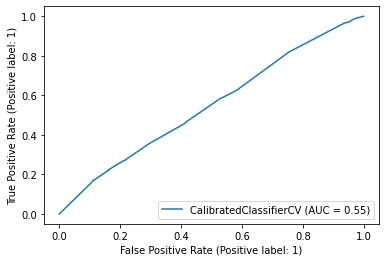

In [359]:
plot_roc_curve(calibrated_model, X_oot.drop('product_id', axis=1), y_oot)

In [355]:
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_multi_prod.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

<h4>Формирование сегмента клиентов для пилота</h4>

In [144]:
df_prod_score = prod_features.merge(feature_matrix_score, how='right')
X_score = df_prod_score.drop(['user_id'], axis=1)

In [145]:
scores = pipeline.predict_proba(X_score)

In [146]:
score_df = pd.DataFrame()
score_df['customer_id'] = df_prod_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [147]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([2266, 2116, 2302, 386, 1797, 2342, 77, 456, 86, 2221, 1485, 1850,
       2002, 2119, 510, 715, 1649, 2148, 2068, 1164, 1964, 1921, 1572, 31,
       1031, 178], dtype=object)

<h3>Домашнее задание 4</h3>
<br>
Сбор витрины<br>
Добавьте информацию о пяти наиболее популярных товарах относящихся к категориям 'MEAT', 'MEAT-WHSE', 'MEAT-PCKGD' или 'PORK'.

<b><i>Подсказка:</i></b> Создайте массив со всеми product_id, относящихся к этим категориям и используйте фильтрацию c помощью метода isin().

<br>
<h1>Практика 4</h1>
<h3>Построение модели склонности для клиентов без истории</h3>

<h4>Сбор обучающей выборки</h4>

In [148]:
# создадим еще одну сущность EntitySet, содержащую меньше признаков, например, не учитывающую предпочтения в категориях
es = ft.EntitySet("a2nced_sample")

In [149]:
# сначала добавим созданные датафреймы
es.add_dataframe(dataframe_name='customer_info',
                 dataframe=demographics,
                 index='user_id')

es.add_dataframe(dataframe_name='orders',
                 dataframe=orders_df,
                 index='basket_id',
                 time_index='purch_date_time')

es.add_dataframe(dataframe_name='transactions',
                dataframe=transactions_df.loc[transactions_df.user_id.isin(available_ids)],
                index='record_id',
                time_index='purch_date_time')

es.add_dataframe(dataframe_name='products',
                dataframe=prod_df,
                index='product_id')

Entityset: a2nced_sample
  DataFrames:
    customer_info [Rows: 801, Columns: 8]
    orders [Rows: 276484, Columns: 7]
    transactions [Rows: 1427303, Columns: 9]
    products [Rows: 92353, Columns: 7]
  Relationships:
    No relationships

In [150]:
# теперь укажем поля для построения связей между ними
es.add_relationship('customer_info', 'user_id', 'orders', 'user_id')
es.add_relationship('customer_info', 'user_id', 'transactions', 'user_id')
es.add_relationship('orders', 'basket_id', 'transactions', 'basket_id')
es.add_relationship('products', 'product_id', 'transactions', 'product_id')

Entityset: a2nced_sample
  DataFrames:
    customer_info [Rows: 801, Columns: 8]
    orders [Rows: 276484, Columns: 7]
    transactions [Rows: 1427303, Columns: 9]
    products [Rows: 92353, Columns: 7]
  Relationships:
    orders.user_id -> customer_info.user_id
    transactions.user_id -> customer_info.user_id
    transactions.basket_id -> orders.basket_id
    transactions.product_id -> products.product_id

In [151]:
# первый заказ какого-либо товара
# используем менее насыщенный признаками датаст
df = create_feature_matrix(es, '2018-10-08')

Built 295 features
Elapsed: 00:03 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:04 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:06 | Progress: 100%|██████████


<h4>Разметка целевого события</h4>

In [152]:
# используем для выявления целевых событий и отсечения ложноположительных случаев операции над множествами (разность множеств)
prev_buy = set(transactions_df.loc[(transactions_df.user_id.isin(available_ids))\
                                   &(transactions_df.purch_date_time <=dt.datetime(2018, 10, 8))\
                                   &(transactions_df.product_id==1082185)]['user_id'].unique())
cur_buy = set(transactions_df.loc[(transactions_df.user_id.isin(available_ids))\
                                  &(transactions_df.purch_date_time >=dt.datetime(2018, 10, 8))\
                                  &(transactions_df.purch_date_time < dt.datetime(2018, 10, 22))\
                                  &(transactions_df.product_id==1082185)]['user_id'].unique())

In [153]:
target = pd.DataFrame()
target['user_id'] = list(cur_buy.difference(prev_buy))
target['y'] = 1
df = df.merge(target, how='left', on='user_id')

df['y'] = df['y'].fillna(0)
df['y'] = df['y'].astype('int8')

y = df['y']
X = df.drop(columns=['y', 'user_id'], axis=1)

In [154]:
y.value_counts()

0    736
1     65
Name: y, dtype: int64

<h3>Домашнее задание 5</h3>
<br>
Для полученной выборки разметьте таргет<br>
Целевое событие: первая покупка клиентом товара с id 1029743 в период двух недель от даты витрины.

<b><i>Подсказка:</i></b> Можно использовать предложенный подход либо определить для каждого клиента дату первой покупки указанного товара и отфильтровать ее по дате.

<h3>Подбор оптимальных гиперпараметров и обучение модели</h3>

In [155]:
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')

In [156]:
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [158]:
categorical_features = X_train.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [159]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [160]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [06:35<00:00,  3.96s/trial, best loss: -0.4852779150968218]


In [161]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['have_own_house',
                                                   'num_adults', 'no_kids',
                                                   'COUNT(orders)_14_days',
                                                   'MAX(orders.default_price)_14_days',
                                                   'MAX(orders.quantity)_14_days',
                                                   'MAX(orders.retail_disc)_14_days',
                                                   'MAX(orders.sales_value)_14_days',
                                                   '...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'adult_gender', 'size'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.3075738476672344, max_depth=13,
                                n_estimators=550, n_jobs=8, num_leaves=84,
                                objective='binary', random_state=42,
                                reg_alpha=0.2718032266690508,
                                reg_lambda=0.6286264788030634))])

In [162]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['have_own_house',
                                                   'num_adults', 'no_kids',
                                                   'COUNT(orders)_14_days',
                                                   'MAX(orders.default_price)_14_days',
                                                   'MAX(orders.quantity)_14_days',
                                                   'MAX(orders.retail_disc)_14_days',
                                                   'MAX(orders.sales_value)_14_days',
                                                   '...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'adult_gender', 'size'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.3075738476672344, max_depth=13,
                                n_estimators=550, n_jobs=8, num_leaves=84,
                                objective='binary', random_state=42,
                                reg_alpha=0.2718032266690508,
                                reg_lambda=0.6286264788030634))])

In [163]:
y_pred = pipeline.predict(X_test)

In [164]:
prob_pred = pipeline.predict_proba(X_test)

In [165]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.845771144278607


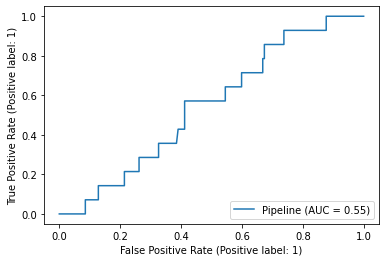

In [166]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [167]:
df_oot  = create_feature_matrix(es, '2018-10-22')

Built 295 features
Elapsed: 00:04 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:06 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:08 | Progress: 100%|██████████


In [168]:
prev_buy = set(transactions_df.loc[(transactions_df.user_id.isin(available_ids))\
                                   &(transactions_df.purch_date_time <=dt.datetime(2018, 10, 22))\
                                   &(transactions_df.product_id==1082185)]['user_id'].unique())

In [169]:
cur_buy = set(transactions_df.loc[(transactions_df.user_id.isin(available_ids))\
                                  &(transactions_df.purch_date_time >=dt.datetime(2018, 10, 22))\
                                  &(transactions_df.purch_date_time < dt.datetime(2018, 11, 5))\
                                  &(transactions_df.product_id==1082185)]['user_id'].unique())

In [170]:
target = pd.DataFrame()
target['user_id'] = list(cur_buy.difference(prev_buy))
target['y'] = 1
df_oot = df_oot.merge(target, how='left', on='user_id')

df_oot['y'] = df_oot['y'].fillna(0)
df_oot['y'] = df_oot['y'].astype('int8')

y_oot = df_oot['y']
X_oot = df_oot.drop(columns=['y', 'user_id'], axis=1)

In [171]:
y_oot.value_counts()

0    747
1     54
Name: y, dtype: int64

In [172]:
for column in X_oot.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X_oot[column] = X_oot[column].astype('object')
X_oot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Columns: 871 entries, age_desc to SUM(transactions.orders.sales_value)_60_days
dtypes: Int64(45), float64(783), object(43)
memory usage: 5.4+ MB


In [173]:
X_oot = X_oot.replace({'<NA>': np.nan})
X_oot = X_oot.replace({True: 1, False: 0})
X_oot = X_oot.replace({pd.NA: np.nan})

In [174]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [175]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.8601747815230961


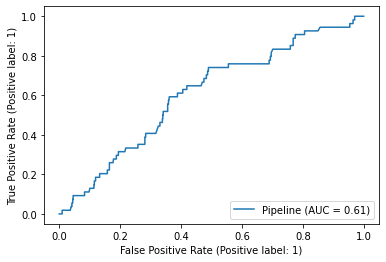

In [176]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [177]:
from utils.metrics import plot_metrics

In [178]:
import ipywidgets as widgets
thr_hold = widgets.FloatSlider(value=0.5,
                               min=0.0,
                               max=1.0,
                               step=0.01)

In [179]:
def plot_con(threshold):
    plot_metrics(y_oot, y_pred_prob_oot, threshold)


    precision: 0.08571428571428572 
    recall: 0.1111111111111111 
    f1: 0.0967741935483871
    


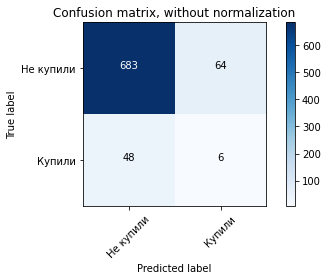

<function __main__.plot_con(threshold)>

In [180]:
widgets.interact(plot_con,
                 threshold=thr_hold)

In [181]:
from utils.metrics import get_feature_names

In [182]:
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])
feature_importance = []


for i, feature in enumerate(pipeline.steps[1][1].feature_importances_):
    feature_importance.append((feature_names[i], feature))
    
    
feature_importance.sort(key=lambda x:x[1], reverse=True)
feature_importance[:10]

[('numeric__have_own_house', 195),
 ('encoder__x1_150-174K', 123),
 ('numeric__num_adults', 89),
 ('encoder__x0_35-44', 71),
 ('encoder__x3_2', 55),
 ('encoder__x0_65+', 53),
 ('encoder__x1_50-74K', 52),
 ('encoder__x0_45-54', 47),
 ('encoder__x3_4', 46),
 ('encoder__x1_25-34K', 42)]

In [183]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
684  0.027385  0.972615  0
217  0.032471  0.967529  0
57   0.040366  0.959634  0
173  0.042963  0.957037  0
363  0.062770  0.937230  0
670  0.075217  0.924783  0
435  0.085069  0.914931  0
327  0.086238  0.913762  1
712  0.105053  0.894947  0
289  0.106885  0.893115  0

In [184]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
684  0.972615  0           0         1   0.000000      1.001248     0.000000   
217  0.967529  0           0         2   0.000000      1.002497     0.000000   
57   0.959634  0           0         3   0.000000      1.003745     0.000000   
173  0.957037  0           0         4   0.000000      1.004994     0.000000   
363  0.937230  0           0         5   0.000000      1.006242     0.000000   
670  0.924783  0           0         6   0.000000      1.007491     0.000000   
435  0.914931  0           0         7   0.000000      1.008739     0.000000   
327  0.913762  1           1         8   0.018519      1.009988     0.018519   
712  0.894947  0           1         9   0.018519      1.011236     0.000000   
289  0.893115  0           1        10   0.018519      1.012484     0.000000   

     position_diff   derivative  sum_derivative  
684       0.000000     0.000000        0.000000  
217       0.001248  1248.439451     1248.439451  
57        0.001248  1248.439451     2496.878901  
173       0.001248  1248.439451     3745.318352  
363       0.001248  1248.439451     4993.757803  
670       0.001248  1248.439451     6242.197253  
435       0.001248  1248.439451     7490.636704  
327       0.001248     0.067412     7490.704116  
712       0.001248  1248.439451     8739.143567  
289       0.001248  1248.439451     9987.583018

In [185]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

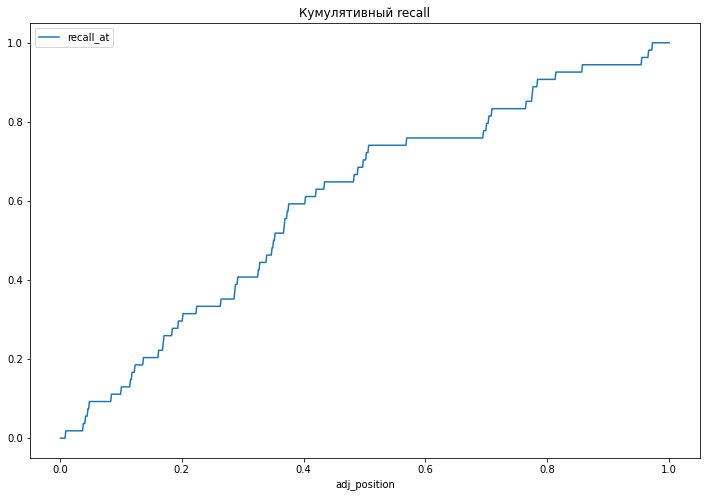

In [186]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [187]:
cutoff = find_inflection_point(scores_sorted, 5, 4, 801)

In [188]:
cutoff = cutoff / scores_sorted.shape[0]

In [189]:
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_new_clients.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(pipeline, pickle_file)

<h4>Формирование сегмента клиентов для пилота</h4>

In [190]:
df_score = create_feature_matrix(es, '2018-11-05')

Built 295 features
Elapsed: 00:05 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:07 | Progress: 100%|██████████
Built 295 features
Elapsed: 00:09 | Progress: 100%|██████████


In [191]:
X_score = df_score.drop(columns=['user_id'], axis=1)

In [192]:
for column in X_score.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X_score[column] = X_score[column].astype('object')
X_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Columns: 871 entries, age_desc to SUM(transactions.orders.sales_value)_60_days
dtypes: Int64(45), float64(783), object(43)
memory usage: 5.4+ MB


In [193]:
X_score = X_score.replace({'<NA>': np.nan})
X_score = X_score.replace({True: 1, False: 0})
X_score = X_score.replace({pd.NA: np.nan})

In [194]:
scores = pipeline.predict_proba(X_score)

In [195]:
score_df = pd.DataFrame()
score_df['customer_id'] = df_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [196]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

[2140, 1494, 1300, 1337, 2221, ..., 2359, 1470, 844, 947, 460]
Length: 26
Categories (801, int64): [1, 7, 8, 13, ..., 2496, 2497, 2498, 2499]

<br>
<h1>Практика 5</h1>
<h3>Построение модели склонности для естественного трафика</h3>

<h4>Сбор обучающей выборки</h4>

In [197]:
# подготовим данные
transactions_df['month'] = pd.DatetimeIndex(transactions_df['purch_date_time']).month
transactions_df['season'] = transactions_df['month'].apply(lambda x: x%12 // 3 + 1)
transactions_df['weekday'] = pd.DatetimeIndex(transactions_df['purch_date_time']).weekday
transactions_df['hour'] = pd.DatetimeIndex(transactions_df['purch_date_time']).hour
transactions_df.head()

user_id     purch_date_time    basket_id  product_id  quantity  \
0     2375 2018-07-31 17:31:00  26984851472     1004906         1   
1     2375 2018-07-31 17:31:00  26984851472     1033142         1   
2     2375 2018-07-31 17:31:00  26984851472     1036325         1   
3     2375 2018-07-31 17:31:00  26984851472     1082185         1   
4     2375 2018-07-31 17:31:00  26984851472     8160430         1   

   sales_value  retail_disc  default_price  record_id  month  season  weekday  \
0         1.39        -0.60           1.99          0      7       3        1   
1         0.82         0.00           0.82          1      7       3        1   
2         0.99        -0.30           1.29          2      7       3        1   
3         1.21         0.00           1.21          3      7       3        1   
4         1.50        -0.39           1.89          4      7       3        1   

   hour  
0    17  
1    17  
2    17  
3    17  
4    17

In [198]:
df = transactions_df.groupby(['season', 'month', 'weekday', 'hour', 'product_id'])['product_id'].count() \
/ transactions_df.groupby(['season', 'month', 'weekday', 'hour'])['product_id'].count()

In [199]:
df = df.to_frame()
df.rename({'product_id':'share'}, axis=1, inplace=True)
df_2 = df.reset_index()
df_2.sort_values(['season', 'month', 'weekday', 'hour', 'share'],
                 ascending=[True,True,True,True,False])
df_2.sample(10)

season  month  weekday  hour  product_id     share
1379347       3      7        3    12      904360  0.000853
1742683       4     10        1    16     1023720  0.002255
1575316       3      8        6    20      835618  0.000597
606941        2      3        2    13    13115913  0.000705
658324        2      3        4    14      977543  0.000243
1281848       3      6        5    18      927191  0.000846
422306        1     12        2    15     1065017  0.000464
473969        1     12        4    16      885917  0.000338
459505        1     12        3    22     7441391  0.000835
1896890       4     11        1    12      871754  0.000763

In [200]:
# напишем простую функцию, которая будет возвращать нам информацию о наиболее подходящих товарах
def propensity_score_sort(data:pd.DataFrame,
                          season:int=None,
                          month:int=None,
                          weekday:int=None,
                          hour:int=None) -> pd.DataFrame:
    """
    
    """
    if month is None or (month < 0 or month > 12):
        month = dt.datetime.now().month
    if season is None or (season < 0 or season > 4):
        season = month % 12 // 3 + 1
    if weekday is None or (weekday < 0 or weekday > 7):
        weekday = dt.datetime.now().weekday()
    if hour is None or (hour < 0 or hour > 12):
        hour = dt.datetime.now().hour
    
    mask = ((data.season == season)\
                &(data.month == month)\
                &(data.weekday == weekday)\
                &(data.hour == hour))
    return(data.loc[mask][['product_id', 'share']].sort_values('share', ascending=False))
    

In [201]:
# Протестируем на параметрах по умолчанию
propensity_score_sort(df_2).head(10)

product_id     share
1912734     1082185  0.010431
1912531     1029743  0.005216
1913051     6534178  0.004742
1912371      995242  0.004267
1912118      930118  0.003793
1912912     1127831  0.003793
1911910      883404  0.003319
1912802     1098066  0.003319
1913012     5978656  0.003319
1912727     1081177  0.003319

In [202]:
# а теперь конкретизируем запрос для определенного момента времени
propensity_score_sort(df_2, 1, 1, 1, 1).head(10)

product_id     share
22983     1082185  0.024194
22949     1012587  0.008065
22919      951590  0.008065
22907      907014  0.008065
23038     2025911  0.008065
22956     1029743  0.008065
22884      854852  0.008065
22883      849843  0.008065
22898      883404  0.008065
23051     5569230  0.008065

<br>
<h1>Практика 6</h1>
<h3>Гиперсегментация - построение модели склонности для целевого трафика</h3>
<br>
<h4>Сбор обучающей выборки</h4>

In [203]:
# добавим информацию о категории, в которой совершен заказ
catigs = transactions_df.merge(prod_df[['product_id', 'department']], how='left', on='product_id')

In [204]:
# Данные для рекламной кампании
df = demographics[['user_id', 'age_desc', 'adult_gender', 'income_desc', 'no_kids']]

In [205]:
start_period = dt.datetime.strptime('2019-07-01', '%Y-%m-%d') + dt.timedelta(days=1)
end_period =  dt.datetime.strptime('2019-07-01', '%Y-%m-%d')  + dt.timedelta(days=14)

<h4>Разметка целевого события</h4>

In [206]:
# почситаем, сколько человек делало покупки в категории PASTRY за две недели
target = pd.DataFrame()
target['user_id'] = catigs[(catigs.department=='PASTRY') & (catigs.purch_date_time >= start_period) & (catigs.purch_date_time <= end_period)]['user_id'].unique()
target['y'] = 1

In [207]:
df = df.merge(target, how='left', on='user_id')
df['y'] = df['y'].fillna(0).astype('int8')
df.y.value_counts()

0    560
1    241
Name: y, dtype: int64

In [208]:
cat_features = ['age_desc', 'adult_gender', 'income_desc', 'no_kids']

In [209]:
pipeline = create_pipeline(cat_features=cat_features,
                          numer_features=[],
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [210]:
X = df.drop(columns=['y', 'user_id'], axis=1)
y = df['y']

In [211]:
for column in X.select_dtypes(exclude=['Int64', 'float64']).columns.values:
    X[column] = X[column].astype('object')
    
X = X.replace({'<NA>': np.nan})
X = X.replace({True: 1, False: 0})
X = X.replace({pd.NA: np.nan})

<h4>Подбор оптимальных значений гиперпараметров и обучение модели</h4>

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [213]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [00:10<00:00,  9.29trial/s, best loss: -0.5336465853993028]


In [214]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'adult_gender',
                                                   'income_desc',
                                                   'no_kids'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.12285059150600686, max_depth=12,
                                n_estimators=850, n_jobs=8, num_leaves=10,
                                objective='binary', random_state=42,
                                reg_alpha=0.5261416216417611,
                                reg_lambda=0.3018806023634624))])

In [215]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_desc', 'adult_gender',
                                                   'income_desc',
                                                   'no_kids'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.12285059150600686, max_depth=12,
                                n_estimators=850, n_jobs=8, num_leaves=10,
                                objective='binary', random_state=42,
                                reg_alpha=0.5261416216417611,
                                reg_lambda=0.3018806023634624))])

In [216]:
y_pred = pipeline.predict(X_test)

In [217]:
prob_pred = pipeline.predict_proba(X_test)

<h4>Оценка качества модели</h4>

In [218]:
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.5572139303482587


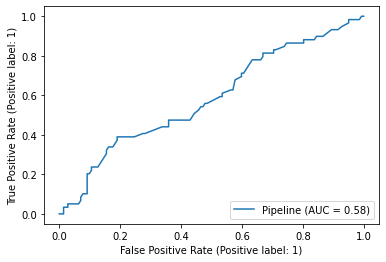

In [219]:
plot_roc_curve(pipeline, X_test, y_test)

<h4>Оценка качества модели на отложенной выборке (ООТ - Out Of Time)</h4>

In [220]:
start_period = dt.datetime.strptime('2019-07-15', '%Y-%m-%d') + dt.timedelta(days=1)
end_period =  dt.datetime.strptime('2019-07-15', '%Y-%m-%d')  + dt.timedelta(days=14)

In [221]:
# почситаем, сколько человек делало покупки в категории PASTRY за две недели
target = pd.DataFrame()
target['user_id'] = catigs[(catigs.department=='PASTRY') & (catigs.purch_date_time >= start_period) & (catigs.purch_date_time <= end_period)]['user_id'].unique()
target['y'] = 1

In [222]:
df.drop('y', axis=1, inplace=True)

df = df.merge(target, how='left', on='user_id')
df['y'] = df['y'].fillna(0).astype('int8')
df.y.value_counts()

0    557
1    244
Name: y, dtype: int64

In [223]:
X_oot = df.drop(columns=['y', 'user_id'], axis=1)
y_oot = df['y']

In [224]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [225]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.5493133583021224


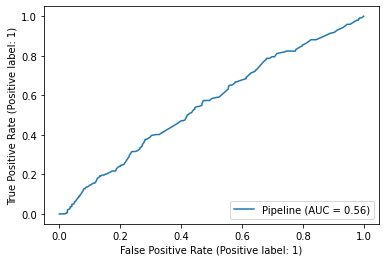

In [226]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [227]:
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_2_targeted.pkl')

with open(_FILEPATH, 'wb') as pickle_file:
    pickle.dump(calibrated_model, pickle_file)

In [228]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
349  0.209519  0.790481  0
22   0.210489  0.789511  0
753  0.210489  0.789511  0
695  0.210489  0.789511  0
354  0.229766  0.770234  0
682  0.229766  0.770234  0
73   0.248225  0.751775  0
162  0.254078  0.745922  0
704  0.254820  0.745180  0
29   0.254820  0.745180  0

In [229]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
349  0.790481  0           0         1        0.0      1.001248          0.0   
695  0.789511  0           0         4        0.0      1.004994          0.0   
22   0.789511  0           0         2        0.0      1.002497          0.0   
753  0.789511  0           0         3        0.0      1.003745          0.0   
682  0.770234  0           0         6        0.0      1.007491          0.0   
354  0.770234  0           0         5        0.0      1.006242          0.0   
73   0.751775  0           0         7        0.0      1.008739          0.0   
162  0.745922  0           0         8        0.0      1.009988          0.0   
704  0.745180  0           0         9        0.0      1.011236          0.0   
29   0.745180  0           0        10        0.0      1.012484          0.0   

     position_diff   derivative  sum_derivative  
349       0.000000     0.000000        0.000000  
695       0.001248  1248.439451     3745.318352  
22        0.001248  1248.439451     1248.439451  
753       0.001248  1248.439451     2496.878901  
682       0.001248  1248.439451     6242.197253  
354       0.001248  1248.439451     4993.757803  
73        0.001248  1248.439451     7490.636704  
162       0.001248  1248.439451     8739.076155  
704       0.001248  1248.439451     9987.515605  
29        0.001248  1248.439451    11235.955056

In [230]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

In [231]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

In [232]:
cutoff = find_inflection_point(scores_sorted, 5, 4, 801, step=25)

In [233]:
cutoff

37

In [234]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Формирование сегмента клиентов для пилота</h4>

In [235]:
X_score = df.drop(['user_id', 'y'], axis=1)

In [236]:
scores = pipeline.predict_proba(X_score)

In [237]:
score_df = pd.DataFrame()
score_df['customer_id'] = df.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [238]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([1038,   56, 2342, 2181, 1053, 2133,  214,  462, 2194,   78,  576,
       1749,  454, 1291, 1831,  631,  732, 1130,  898, 2084, 1376,  993,
        493,  660,  289,  413, 2087,  908, 2102, 1364, 1389,  119, 1402,
       2063, 1081, 1357,  996, 2224])